In [1]:
import sys
# sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import h5py

In [2]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q - lambda_1*(tf.math.sqrt(tf.math.square(u_x) + tf.math.square(u_t))) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [3]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\K1 ND K0.5_.csv")

In [4]:
q_z= df.loc[:,["Directional Heat Flux (Z)" ]] 

In [5]:
q_z_new=np.array(q_z)

In [6]:
q_z_new_sq=np.square(q_z_new)

In [7]:
q_x= df.loc[:,["Directional Heat Flux (X)" ]] 

In [8]:
q_x_new=np.array(q_x)

In [9]:
q_x_new_sq=np.square(q_x_new)

In [10]:
q_final = np.sqrt((q_x_new_sq+q_z_new_sq))

In [11]:
x_y=df.loc[:,["X Location (m)","Z Location (m)" ]] 

In [12]:
x_y=np.array(x_y)

In [13]:
u=df.loc[:,"Temperature (°C)"]

In [14]:
u=np.array(u)

In [15]:
u=u.reshape(160801,1)

In [16]:
N_u_1=3000
layers1 = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [17]:
lb1 = x_y.min(0)
ub1 = x_y.max(0)

In [18]:
idx = np.random.choice(x_y.shape[0], N_u_1, replace=False)
X_u_train = x_y[idx,:]
u_train = u[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)



In [20]:
model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 1.055e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.69
It: 10, Loss: 8.167e-01, Lambda_1: 0.010, Lambda_2: 1.000000, Time: 0.16
It: 20, Loss: 7.016e-01, Lambda_1: 0.019, Lambda_2: 1.000000, Time: 0.12
It: 30, Loss: 6.716e-01, Lambda_1: 0.028, Lambda_2: 1.000000, Time: 0.13
It: 40, Loss: 6.726e-01, Lambda_1: 0.036, Lambda_2: 1.000000, Time: 0.12
It: 50, Loss: 6.730e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.27
It: 60, Loss: 6.713e-01, Lambda_1: 0.054, Lambda_2: 1.000000, Time: 0.16
It: 70, Loss: 6.708e-01, Lambda_1: 0.064, Lambda_2: 1.000000, Time: 0.16
It: 80, Loss: 6.709e-01, Lambda_1: 0

It: 1060, Loss: 2.871e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.09
It: 1070, Loss: 2.864e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.12
It: 1080, Loss: 2.858e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.11
It: 1090, Loss: 2.850e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.12
It: 1100, Loss: 2.842e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.12
It: 1110, Loss: 2.833e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.11
It: 1120, Loss: 2.824e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 1130, Loss: 2.813e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 1140, Loss: 2.801e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.09
It: 1150, Loss: 2.788e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.10
It: 1160, Loss: 2.774e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 1170, Loss: 2.759e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.11
It: 1180, Loss: 2.743e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.10
It: 1190, Loss: 2.726e-01

It: 2170, Loss: 4.573e-02, Lambda_1: 0.765, Lambda_2: 1.000000, Time: 0.11
It: 2180, Loss: 4.508e-02, Lambda_1: 0.764, Lambda_2: 1.000000, Time: 0.12
It: 2190, Loss: 4.445e-02, Lambda_1: 0.764, Lambda_2: 1.000000, Time: 0.11
It: 2200, Loss: 4.406e-02, Lambda_1: 0.763, Lambda_2: 1.000000, Time: 0.11
It: 2210, Loss: 4.325e-02, Lambda_1: 0.762, Lambda_2: 1.000000, Time: 0.13
It: 2220, Loss: 4.277e-02, Lambda_1: 0.761, Lambda_2: 1.000000, Time: 0.10
It: 2230, Loss: 4.219e-02, Lambda_1: 0.760, Lambda_2: 1.000000, Time: 0.13
It: 2240, Loss: 4.160e-02, Lambda_1: 0.760, Lambda_2: 1.000000, Time: 0.10
It: 2250, Loss: 4.104e-02, Lambda_1: 0.759, Lambda_2: 1.000000, Time: 0.12
It: 2260, Loss: 4.048e-02, Lambda_1: 0.758, Lambda_2: 1.000000, Time: 0.11
It: 2270, Loss: 3.993e-02, Lambda_1: 0.757, Lambda_2: 1.000000, Time: 0.12
It: 2280, Loss: 3.937e-02, Lambda_1: 0.756, Lambda_2: 1.000000, Time: 0.10
It: 2290, Loss: 3.882e-02, Lambda_1: 0.755, Lambda_2: 1.000000, Time: 0.12
It: 2300, Loss: 3.826e-02

It: 3270, Loss: 1.502e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.12
It: 3280, Loss: 1.491e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.11
It: 3290, Loss: 1.488e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.13
It: 3300, Loss: 1.510e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.11
It: 3310, Loss: 1.473e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.12
It: 3320, Loss: 1.476e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.11
It: 3330, Loss: 1.462e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.13
It: 3340, Loss: 1.463e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.10
It: 3350, Loss: 1.474e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.12
It: 3360, Loss: 1.447e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.11
It: 3370, Loss: 1.446e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.12
It: 3380, Loss: 1.449e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.11
It: 3390, Loss: 1.436e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.13
It: 3400, Loss: 1.426e-02

It: 4370, Loss: 1.168e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.12
It: 4380, Loss: 1.167e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.11
It: 4390, Loss: 1.167e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.13
It: 4400, Loss: 1.165e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.10
It: 4410, Loss: 1.162e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.12
It: 4420, Loss: 1.161e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.11
It: 4430, Loss: 1.159e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.13
It: 4440, Loss: 1.159e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.10
It: 4450, Loss: 1.188e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.13
It: 4460, Loss: 1.154e-02, Lambda_1: 0.704, Lambda_2: 1.000000, Time: 0.11
It: 4470, Loss: 1.155e-02, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 1.154e-02, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.11
It: 4490, Loss: 1.151e-02, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.12
It: 4500, Loss: 1.148e-02

It: 5470, Loss: 1.013e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.12
It: 5480, Loss: 1.011e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.11
It: 5490, Loss: 1.010e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.12
It: 5500, Loss: 1.009e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.10
It: 5510, Loss: 1.008e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.12
It: 5520, Loss: 1.006e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.11
It: 5530, Loss: 1.005e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.12
It: 5540, Loss: 1.008e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.11
It: 5550, Loss: 1.071e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.13
It: 5560, Loss: 1.018e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.10
It: 5570, Loss: 1.000e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.12
It: 5580, Loss: 1.003e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.11
It: 5590, Loss: 9.988e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.14
It: 5600, Loss: 9.965e-03

It: 6570, Loss: 8.990e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6580, Loss: 8.979e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6590, Loss: 8.975e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6600, Loss: 8.959e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6610, Loss: 8.948e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 6620, Loss: 8.939e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6630, Loss: 8.930e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 6640, Loss: 8.923e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 6650, Loss: 8.915e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6660, Loss: 8.908e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 6670, Loss: 8.909e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 6680, Loss: 9.178e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 6690, Loss: 8.945e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 6700, Loss: 8.913e-03

It: 7670, Loss: 8.356e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 7680, Loss: 8.555e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 7690, Loss: 8.410e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 7700, Loss: 8.354e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 7710, Loss: 8.315e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.11
It: 7720, Loss: 8.290e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.11
It: 7730, Loss: 8.293e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.11
It: 7740, Loss: 8.292e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 7750, Loss: 8.348e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 7760, Loss: 8.371e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.10
It: 7770, Loss: 8.299e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.10
It: 7780, Loss: 8.299e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.10
It: 7790, Loss: 8.260e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.11
It: 7800, Loss: 8.258e-03

It: 8770, Loss: 7.934e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.13
It: 8780, Loss: 7.933e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.11
It: 8790, Loss: 8.011e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.11
It: 8800, Loss: 7.983e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.13
It: 8810, Loss: 8.007e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.10
It: 8820, Loss: 7.985e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.11
It: 8830, Loss: 7.929e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.12
It: 8840, Loss: 7.933e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.09
It: 8850, Loss: 7.915e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.10
It: 8860, Loss: 7.915e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.10
It: 8870, Loss: 8.033e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.12
It: 8880, Loss: 7.920e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.11
It: 8890, Loss: 7.981e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.09
It: 8900, Loss: 7.948e-03

It: 9880, Loss: 7.724e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.14
It: 9890, Loss: 7.783e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.13
It: 9900, Loss: 7.699e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.14
It: 9910, Loss: 7.685e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.12
It: 9920, Loss: 7.688e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.14
It: 9930, Loss: 7.946e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.36
It: 9940, Loss: 7.709e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 9950, Loss: 7.681e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 9960, Loss: 7.724e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 9970, Loss: 7.691e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.32
It: 9980, Loss: 7.703e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.33
It: 9990, Loss: 7.699e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.26
It: 10000, Loss: 7.748e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 10010, Loss: 7.718e-

It: 10960, Loss: 7.595e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 10970, Loss: 7.557e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 10980, Loss: 7.519e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 10990, Loss: 7.517e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 11000, Loss: 7.547e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.23
It: 11010, Loss: 7.750e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 11020, Loss: 7.678e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 11030, Loss: 7.580e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.14
It: 11040, Loss: 7.512e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 11050, Loss: 7.545e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.14
It: 11060, Loss: 7.515e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 11070, Loss: 7.524e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.13
It: 11080, Loss: 7.683e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.13
It: 11090, L

It: 12040, Loss: 7.405e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 12050, Loss: 7.436e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 12060, Loss: 7.482e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 12070, Loss: 7.391e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 12080, Loss: 7.420e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 12090, Loss: 7.557e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 12100, Loss: 7.402e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 12110, Loss: 7.471e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 12120, Loss: 7.390e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 12130, Loss: 7.385e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.18
It: 12140, Loss: 7.411e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.15
It: 12150, Loss: 7.625e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 12160, Loss: 7.502e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.14
It: 12170, L

It: 13120, Loss: 7.296e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 13130, Loss: 7.358e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 13140, Loss: 7.318e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 13150, Loss: 7.313e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 13160, Loss: 7.424e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 13170, Loss: 7.300e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.12
It: 13180, Loss: 7.315e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 13190, Loss: 7.435e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 13200, Loss: 7.289e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 13210, Loss: 7.378e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 13220, Loss: 7.320e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 13230, Loss: 7.291e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 13240, Loss: 7.412e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 13250, L

It: 14200, Loss: 7.246e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 14210, Loss: 7.270e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 14220, Loss: 7.227e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 14230, Loss: 7.274e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 14240, Loss: 7.299e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 14250, Loss: 7.222e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 14260, Loss: 7.343e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 14270, Loss: 7.217e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 14280, Loss: 7.245e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 14290, Loss: 7.339e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 14300, Loss: 7.216e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 14310, Loss: 7.328e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 14320, Loss: 7.218e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 14330, L

It: 15280, Loss: 7.208e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15290, Loss: 7.156e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.18
It: 15300, Loss: 7.279e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.18
It: 15310, Loss: 7.160e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15320, Loss: 7.244e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15330, Loss: 7.177e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15340, Loss: 7.151e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 15350, Loss: 7.207e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15360, Loss: 7.213e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 15370, Loss: 7.264e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15380, Loss: 7.151e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 15390, Loss: 7.186e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 15400, Loss: 7.247e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 15410, L

It: 16360, Loss: 7.176e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 16370, Loss: 7.109e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16380, Loss: 7.239e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16390, Loss: 7.105e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16400, Loss: 7.122e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16410, Loss: 7.250e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 16420, Loss: 7.115e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 16430, Loss: 7.213e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 16440, Loss: 7.099e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 16450, Loss: 7.112e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16460, Loss: 7.304e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16470, Loss: 7.136e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 16480, Loss: 7.141e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 16490, L

It: 17440, Loss: 7.064e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 17450, Loss: 7.193e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 17460, Loss: 7.059e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.26
It: 17470, Loss: 7.077e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.26
It: 17480, Loss: 7.209e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 17490, Loss: 7.086e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.27
It: 17500, Loss: 7.125e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 17510, Loss: 7.054e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 17520, Loss: 7.058e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 17530, Loss: 7.350e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 17540, Loss: 7.103e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 17550, Loss: 7.063e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 17560, Loss: 7.146e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 17570, L

It: 18520, Loss: 7.177e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 18530, Loss: 7.031e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 18540, Loss: 7.098e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 18550, Loss: 7.019e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 18560, Loss: 7.032e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 18570, Loss: 7.212e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 18580, Loss: 7.083e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 18590, Loss: 7.029e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 18600, Loss: 7.056e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 18610, Loss: 7.094e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 18620, Loss: 7.017e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 18630, Loss: 7.174e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 18640, Loss: 7.014e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 18650, L

It: 19600, Loss: 6.984e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 19610, Loss: 6.989e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 19620, Loss: 7.258e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 19630, Loss: 7.060e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 19640, Loss: 6.985e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 19650, Loss: 7.096e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 19660, Loss: 6.990e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 19670, Loss: 6.981e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 19680, Loss: 6.999e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 19690, Loss: 7.117e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 19700, Loss: 7.155e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 19710, Loss: 7.003e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.33
It: 19720, Loss: 7.029e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 19730, L

It: 20680, Loss: 6.954e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 20690, Loss: 7.091e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 20700, Loss: 6.953e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 20710, Loss: 7.050e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 20720, Loss: 6.980e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 20730, Loss: 7.031e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 20740, Loss: 6.951e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 20750, Loss: 6.977e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 20760, Loss: 7.049e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 20770, Loss: 7.082e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 20780, Loss: 6.951e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 20790, Loss: 7.069e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20800, Loss: 6.958e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20810, L

It: 21760, Loss: 7.182e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 21770, Loss: 6.948e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 21780, Loss: 6.959e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 21790, Loss: 6.975e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 21800, Loss: 6.974e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 21810, Loss: 6.925e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21820, Loss: 7.078e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 21830, Loss: 6.924e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21840, Loss: 7.054e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 21850, Loss: 6.924e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21860, Loss: 6.927e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21870, Loss: 7.194e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21880, Loss: 6.971e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 21890, L

It: 22840, Loss: 7.028e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 22850, Loss: 6.898e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 22860, Loss: 6.915e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 22870, Loss: 7.049e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 22880, Loss: 6.994e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 22890, Loss: 6.901e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 22900, Loss: 6.966e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 22910, Loss: 6.928e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 22920, Loss: 6.908e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 22930, Loss: 7.071e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 22940, Loss: 6.901e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.26
It: 22950, Loss: 7.032e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 22960, Loss: 6.899e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 22970, L

It: 23920, Loss: 7.097e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 23930, Loss: 6.882e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 23940, Loss: 6.964e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 23950, Loss: 6.870e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 23960, Loss: 6.874e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 23970, Loss: 7.175e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 23980, Loss: 6.947e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 23990, Loss: 6.870e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 24000, Loss: 6.999e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 24010, Loss: 6.869e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 24020, Loss: 6.948e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 24030, Loss: 6.894e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 24040, Loss: 6.889e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.27
It: 24050, L

It: 25000, Loss: 6.981e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 25010, Loss: 6.905e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 25020, Loss: 6.869e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 25030, Loss: 6.845e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 25040, Loss: 6.975e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 25050, Loss: 6.845e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 25060, Loss: 6.975e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 25070, Loss: 6.844e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 25080, Loss: 6.964e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 25090, Loss: 6.852e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 25100, Loss: 6.873e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 25110, Loss: 6.943e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 25120, Loss: 6.860e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 25130, L

It: 26080, Loss: 6.894e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.26
It: 26090, Loss: 6.832e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.33
It: 26100, Loss: 6.847e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.30
It: 26110, Loss: 6.920e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.30
It: 26120, Loss: 6.821e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.36
It: 26130, Loss: 6.978e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.36
It: 26140, Loss: 6.820e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 26150, Loss: 6.942e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 26160, Loss: 6.833e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 26170, Loss: 6.834e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 26180, Loss: 6.999e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.24
It: 26190, Loss: 6.828e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 26200, Loss: 6.932e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 26210, L

It: 27160, Loss: 6.805e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 27170, Loss: 7.042e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27180, Loss: 6.844e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.18
It: 27190, Loss: 6.816e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 27200, Loss: 6.847e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27210, Loss: 6.838e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27220, Loss: 6.797e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 27230, Loss: 6.922e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27240, Loss: 6.798e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27250, Loss: 6.922e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 27260, Loss: 6.795e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27270, Loss: 6.865e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 27280, Loss: 6.830e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 27290, L

It: 28240, Loss: 6.783e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.45
It: 28250, Loss: 6.959e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.42
It: 28260, Loss: 6.775e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.39
It: 28270, Loss: 6.896e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.35
It: 28280, Loss: 6.783e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.36
It: 28290, Loss: 6.801e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.40
It: 28300, Loss: 6.888e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.39
It: 28310, Loss: 6.781e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.28
It: 28320, Loss: 6.925e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.35
It: 28330, Loss: 6.775e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.40
It: 28340, Loss: 6.786e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.40
It: 28350, Loss: 6.962e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.34
It: 28360, Loss: 6.819e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.37
It: 28370, L

It: 29320, Loss: 6.977e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.31
It: 29330, Loss: 6.769e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.25
It: 29340, Loss: 6.823e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 29350, Loss: 6.753e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 29360, Loss: 6.798e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 29370, Loss: 6.808e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 29380, Loss: 6.858e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 29390, Loss: 6.758e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.26
It: 29400, Loss: 6.762e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 29410, Loss: 6.940e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 29420, Loss: 6.755e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 29430, Loss: 6.889e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 29440, Loss: 6.754e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.31
It: 29450, L

In [22]:
np_loss_array=np.array(model.loss_array)

In [23]:
with h5py.File('loss_array.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array)

In [24]:
np_lambda_array = np.array(model.lambda_array)

In [25]:
with h5py.File('lambda_array.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array)

In [27]:
arr=[]
for i in range(0,30000):
    if i%10==0:
        arr.append(i)

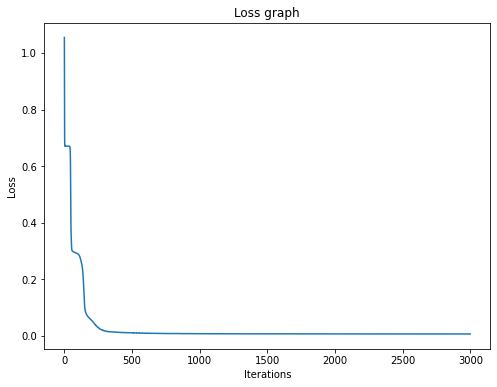

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

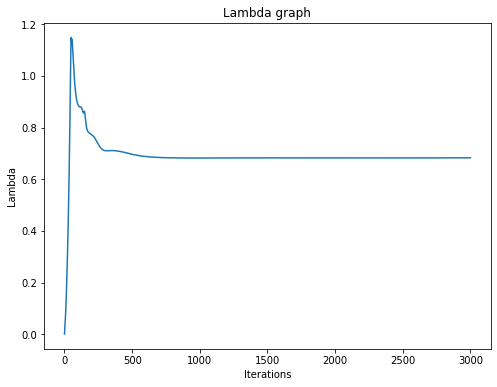

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [25]:
noise2 = 0.01        
u_train2 = u_train + noise2*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_2 = q_ + noise2*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

In [26]:
q_t_2= tf.convert_to_tensor(q_2,dtype=tf.float32)

In [27]:
model2 = PhysicsInformedNN3(X_u_train, u_train2, layers1, lb1, ub1 , q_t_2)
model2.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 7.491e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.53
It: 10, Loss: 5.983e-01, Lambda_1: 0.009, Lambda_2: 1.000000, Time: 0.14
It: 20, Loss: 5.530e-01, Lambda_1: 0.018, Lambda_2: 1.000000, Time: 0.11
It: 30, Loss: 5.555e-01, Lambda_1: 0.027, Lambda_2: 1.000000, Time: 0.13
It: 40, Loss: 5.546e-01, Lambda_1: 0.036, Lambda_2: 1.000000, Time: 0.17
It: 50, Loss: 5.521e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.13
It: 60, Loss: 5.523e-01, Lambda_1: 0.052, Lambda_2: 1.000000, Time: 0.13
It: 70, Loss: 5.522e-01, Lambda_1: 0.060, Lambda_2: 1.000000, Time: 0.11
It: 80, Loss: 5.521e-01, Lambda_1: 0

It: 1060, Loss: 1.919e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.13
It: 1070, Loss: 1.919e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.10
It: 1080, Loss: 1.918e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.11
It: 1090, Loss: 1.918e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.10
It: 1100, Loss: 1.918e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.13
It: 1110, Loss: 1.918e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.10
It: 1120, Loss: 1.917e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.11
It: 1130, Loss: 1.917e-01, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.11
It: 1140, Loss: 1.917e-01, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.12
It: 1150, Loss: 1.917e-01, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.11
It: 1160, Loss: 1.916e-01, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.12
It: 1170, Loss: 1.916e-01, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.11
It: 1180, Loss: 1.916e-01, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.13
It: 1190, Loss: 1.915e-01

It: 2160, Loss: 6.534e-02, Lambda_1: 0.802, Lambda_2: 1.000000, Time: 0.11
It: 2170, Loss: 6.472e-02, Lambda_1: 0.802, Lambda_2: 1.000000, Time: 0.11
It: 2180, Loss: 6.409e-02, Lambda_1: 0.802, Lambda_2: 1.000000, Time: 0.12
It: 2190, Loss: 6.345e-02, Lambda_1: 0.801, Lambda_2: 1.000000, Time: 0.11
It: 2200, Loss: 6.280e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.13
It: 2210, Loss: 6.212e-02, Lambda_1: 0.799, Lambda_2: 1.000000, Time: 0.10
It: 2220, Loss: 6.146e-02, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.12
It: 2230, Loss: 6.076e-02, Lambda_1: 0.796, Lambda_2: 1.000000, Time: 0.11
It: 2240, Loss: 6.004e-02, Lambda_1: 0.795, Lambda_2: 1.000000, Time: 0.12
It: 2250, Loss: 5.929e-02, Lambda_1: 0.794, Lambda_2: 1.000000, Time: 0.10
It: 2260, Loss: 5.851e-02, Lambda_1: 0.793, Lambda_2: 1.000000, Time: 0.13
It: 2270, Loss: 5.769e-02, Lambda_1: 0.791, Lambda_2: 1.000000, Time: 0.10
It: 2280, Loss: 5.683e-02, Lambda_1: 0.790, Lambda_2: 1.000000, Time: 0.13
It: 2290, Loss: 5.593e-02

It: 3260, Loss: 1.390e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.11
It: 3270, Loss: 1.376e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.10
It: 3280, Loss: 1.368e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.12
It: 3290, Loss: 1.362e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.11
It: 3300, Loss: 1.359e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.12
It: 3310, Loss: 1.356e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.10
It: 3320, Loss: 1.359e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.11
It: 3330, Loss: 1.354e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.10
It: 3340, Loss: 1.347e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.11
It: 3350, Loss: 1.343e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.10
It: 3360, Loss: 1.337e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.11
It: 3370, Loss: 1.334e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.11
It: 3380, Loss: 1.339e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.12
It: 3390, Loss: 1.332e-02

It: 4360, Loss: 1.119e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.12
It: 4370, Loss: 1.117e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.11
It: 4380, Loss: 1.117e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.13
It: 4390, Loss: 1.123e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.10
It: 4400, Loss: 1.116e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.11
It: 4410, Loss: 1.113e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.11
It: 4420, Loss: 1.110e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.12
It: 4430, Loss: 1.107e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.11
It: 4440, Loss: 1.105e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.12
It: 4450, Loss: 1.110e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.11
It: 4460, Loss: 1.116e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.12
It: 4470, Loss: 1.108e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.11
It: 4480, Loss: 1.100e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.13
It: 4490, Loss: 1.097e-02

It: 5460, Loss: 9.320e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.12
It: 5470, Loss: 9.324e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.11
It: 5480, Loss: 9.570e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.12
It: 5490, Loss: 9.289e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.10
It: 5500, Loss: 9.273e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.12
It: 5510, Loss: 9.272e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.11
It: 5520, Loss: 9.235e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.12
It: 5530, Loss: 9.227e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.11
It: 5540, Loss: 9.249e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.12
It: 5550, Loss: 9.383e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.11
It: 5560, Loss: 9.196e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.11
It: 5570, Loss: 9.197e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.10
It: 5580, Loss: 9.162e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.11
It: 5590, Loss: 9.169e-03

It: 6560, Loss: 8.377e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 6570, Loss: 8.361e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6580, Loss: 8.354e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 6590, Loss: 8.352e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 6600, Loss: 8.484e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6610, Loss: 8.398e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6620, Loss: 8.391e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6630, Loss: 8.364e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6640, Loss: 8.326e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6650, Loss: 8.318e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6660, Loss: 8.310e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 6670, Loss: 8.309e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 6680, Loss: 8.336e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6690, Loss: 8.476e-03

It: 7660, Loss: 7.991e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 7670, Loss: 7.998e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 7680, Loss: 8.019e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 7690, Loss: 8.041e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 7700, Loss: 8.021e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 7710, Loss: 7.986e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 7720, Loss: 7.979e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 7730, Loss: 7.994e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 7740, Loss: 8.176e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 7750, Loss: 7.974e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 7760, Loss: 8.006e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 7770, Loss: 7.980e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 7780, Loss: 7.975e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 7790, Loss: 7.971e-03

It: 8760, Loss: 7.918e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 8770, Loss: 7.831e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 8780, Loss: 7.828e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 8790, Loss: 7.858e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 8800, Loss: 7.946e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 8810, Loss: 7.824e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 8820, Loss: 7.848e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 8830, Loss: 7.846e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 8840, Loss: 7.839e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 8850, Loss: 7.843e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 8860, Loss: 7.877e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 8870, Loss: 7.925e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 8880, Loss: 7.827e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 8890, Loss: 7.824e-03

It: 9860, Loss: 7.743e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 9870, Loss: 7.814e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 9880, Loss: 7.728e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 9890, Loss: 7.721e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 9900, Loss: 7.742e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 9910, Loss: 7.764e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 9920, Loss: 7.746e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 9930, Loss: 7.724e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 9940, Loss: 7.734e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 9950, Loss: 7.775e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 9960, Loss: 7.776e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 9970, Loss: 7.707e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 9980, Loss: 7.705e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 9990, Loss: 7.720e-03

It: 10940, Loss: 7.626e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 10950, Loss: 7.640e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 10960, Loss: 7.925e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 10970, Loss: 7.652e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 10980, Loss: 7.627e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 10990, Loss: 7.642e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 11000, Loss: 7.624e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 11010, Loss: 7.626e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 11020, Loss: 7.632e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 11030, Loss: 7.670e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 11040, Loss: 7.688e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 11050, Loss: 7.622e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 11060, Loss: 7.624e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 11070, L

It: 12020, Loss: 7.616e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12030, Loss: 7.559e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12040, Loss: 7.564e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12050, Loss: 7.565e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.10
It: 12060, Loss: 7.576e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12070, Loss: 7.634e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12080, Loss: 7.581e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 12090, Loss: 7.555e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12100, Loss: 7.580e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 12110, Loss: 7.640e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.10
It: 12120, Loss: 7.576e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 12130, Loss: 7.551e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 12140, Loss: 7.564e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 12150, L

It: 13100, Loss: 7.572e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 13110, Loss: 7.557e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.10
It: 13120, Loss: 7.500e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 13130, Loss: 7.512e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.10
It: 13140, Loss: 7.563e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 13150, Loss: 7.553e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 13160, Loss: 7.503e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 13170, Loss: 7.531e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.10
It: 13180, Loss: 7.517e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 13190, Loss: 7.507e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.10
It: 13200, Loss: 7.669e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 13210, Loss: 7.546e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 13220, Loss: 7.539e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 13230, L

It: 14180, Loss: 7.458e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14190, Loss: 7.455e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14200, Loss: 7.474e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14210, Loss: 7.662e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 14220, Loss: 7.478e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14230, Loss: 7.463e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 14240, Loss: 7.467e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14250, Loss: 7.458e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 14260, Loss: 7.453e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14270, Loss: 7.452e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 14280, Loss: 7.474e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 14290, Loss: 7.647e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 14300, Loss: 7.470e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 14310, L

It: 15260, Loss: 7.442e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15270, Loss: 7.444e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 15280, Loss: 7.440e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15290, Loss: 7.453e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15300, Loss: 7.451e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15310, Loss: 7.431e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15320, Loss: 7.451e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15330, Loss: 7.467e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 15340, Loss: 7.442e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 15350, Loss: 7.423e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 15360, Loss: 7.412e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.15
It: 15370, Loss: 7.416e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.15
It: 15380, Loss: 7.497e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 15390, L

It: 16340, Loss: 7.380e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16350, Loss: 7.396e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16360, Loss: 7.610e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16370, Loss: 7.387e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16380, Loss: 7.395e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16390, Loss: 7.391e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 16400, Loss: 7.388e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16410, Loss: 7.380e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16420, Loss: 7.388e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16430, Loss: 7.483e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16440, Loss: 7.410e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16450, Loss: 7.392e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 16460, Loss: 7.404e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 16470, L

It: 17420, Loss: 7.360e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.15
It: 17430, Loss: 7.348e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 17440, Loss: 7.359e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 17450, Loss: 7.487e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.16
It: 17460, Loss: 7.349e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.16
It: 17470, Loss: 7.385e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.16
It: 17480, Loss: 7.343e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 17490, Loss: 7.351e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 17500, Loss: 7.366e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 17510, Loss: 7.439e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 17520, Loss: 7.351e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 17530, Loss: 7.364e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 17540, Loss: 7.399e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.16
It: 17550, L

It: 18500, Loss: 7.372e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 18510, Loss: 7.360e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 18520, Loss: 7.309e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 18530, Loss: 7.322e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 18540, Loss: 7.379e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 18550, Loss: 7.363e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 18560, Loss: 7.315e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 18570, Loss: 7.344e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 18580, Loss: 7.337e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 18590, Loss: 7.328e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 18600, Loss: 7.320e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 18610, Loss: 7.329e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 18620, Loss: 7.497e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 18630, L

It: 19580, Loss: 7.328e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.30
It: 19590, Loss: 7.289e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.30
It: 19600, Loss: 7.276e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.34
It: 19610, Loss: 7.278e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.33
It: 19620, Loss: 7.275e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 19630, Loss: 7.275e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.28
It: 19640, Loss: 7.280e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 19650, Loss: 7.357e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 19660, Loss: 7.321e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 19670, Loss: 7.289e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.25
It: 19680, Loss: 7.301e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 19690, Loss: 7.284e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 19700, Loss: 7.284e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 19710, L

It: 20670, Loss: 7.342e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 20680, Loss: 7.266e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 20690, Loss: 7.281e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 20700, Loss: 7.248e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 20710, Loss: 7.244e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 20720, Loss: 7.266e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 20730, Loss: 7.338e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 20740, Loss: 7.262e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 20750, Loss: 7.265e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 20760, Loss: 7.269e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 20770, Loss: 7.258e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 20780, Loss: 7.275e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 20790, Loss: 7.278e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 20800, L

It: 21750, Loss: 7.210e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 21760, Loss: 7.224e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.25
It: 21770, Loss: 7.245e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.25
It: 21780, Loss: 7.262e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 21790, Loss: 7.226e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 21800, Loss: 7.212e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 21810, Loss: 7.220e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 21820, Loss: 7.354e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 21830, Loss: 7.213e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 21840, Loss: 7.249e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 21850, Loss: 7.208e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 21860, Loss: 7.224e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 21870, Loss: 7.236e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 21880, L

It: 22830, Loss: 7.216e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 22840, Loss: 7.205e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 22850, Loss: 7.209e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 22860, Loss: 7.183e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 22870, Loss: 7.227e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 22880, Loss: 7.234e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 22890, Loss: 7.186e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 22900, Loss: 7.174e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 22910, Loss: 7.176e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 22920, Loss: 7.183e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 22930, Loss: 7.457e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 22940, Loss: 7.210e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 22950, Loss: 7.172e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 22960, L

It: 23910, Loss: 7.177e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 23920, Loss: 7.153e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 23930, Loss: 7.150e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 23940, Loss: 7.196e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 23950, Loss: 7.215e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 23960, Loss: 7.143e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 23970, Loss: 7.167e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 23980, Loss: 7.158e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 23990, Loss: 7.152e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 24000, Loss: 7.170e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 24010, Loss: 7.215e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 24020, Loss: 7.140e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 24030, Loss: 7.146e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 24040, L

It: 24990, Loss: 7.102e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 25000, Loss: 7.112e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 25010, Loss: 7.198e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 25020, Loss: 7.142e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 25030, Loss: 7.104e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 25040, Loss: 7.106e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 25050, Loss: 7.144e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 25060, Loss: 7.228e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 25070, Loss: 7.111e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 25080, Loss: 7.119e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 25090, Loss: 7.099e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 25100, Loss: 7.104e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 25110, Loss: 7.164e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 25120, L

It: 26070, Loss: 7.221e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 26080, Loss: 7.103e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 26090, Loss: 7.110e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 26100, Loss: 7.076e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 26110, Loss: 7.081e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 26120, Loss: 7.093e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 26130, Loss: 7.103e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 26140, Loss: 7.107e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 26150, Loss: 7.087e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 26160, Loss: 7.080e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 26170, Loss: 7.114e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 26180, Loss: 7.143e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 26190, Loss: 7.065e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 26200, L

It: 27150, Loss: 7.043e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 27160, Loss: 7.053e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 27170, Loss: 7.136e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 27180, Loss: 7.045e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 27190, Loss: 7.063e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 27200, Loss: 7.061e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 27210, Loss: 7.046e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 27220, Loss: 7.055e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 27230, Loss: 7.130e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 27240, Loss: 7.053e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 27250, Loss: 7.051e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 27260, Loss: 7.069e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 27270, Loss: 7.056e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 27280, L

It: 28230, Loss: 7.010e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 28240, Loss: 7.018e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 28250, Loss: 7.111e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 28260, Loss: 7.036e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 28270, Loss: 7.036e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 28280, Loss: 7.023e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 28290, Loss: 7.013e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 28300, Loss: 7.019e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 28310, Loss: 7.096e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 28320, Loss: 7.033e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 28330, Loss: 7.044e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 28340, Loss: 7.018e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 28350, Loss: 7.010e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 28360, L

It: 29310, Loss: 6.985e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 29320, Loss: 7.081e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 29330, Loss: 6.985e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 29340, Loss: 6.982e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 29350, Loss: 6.983e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 29360, Loss: 6.989e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 29370, Loss: 6.985e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 29380, Loss: 6.982e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 29390, Loss: 6.981e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 29400, Loss: 6.982e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 29410, Loss: 7.019e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 29420, Loss: 7.074e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 29430, Loss: 7.000e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 29440, L

In [28]:
np_loss_array_2=np.array(model2.loss_array)

In [29]:
with h5py.File('loss_array_2.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_2)

In [30]:
np_lambda_array_2 = np.array(model2.lambda_array)

In [31]:
with h5py.File('lambda_array_2.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_2)

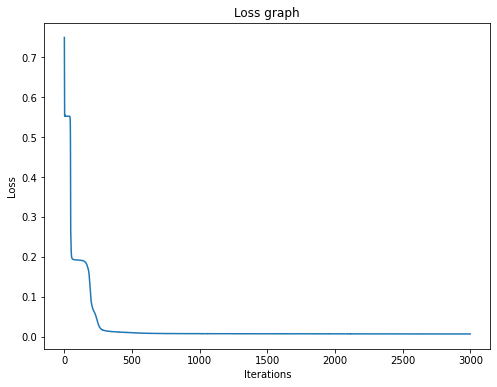

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model2.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

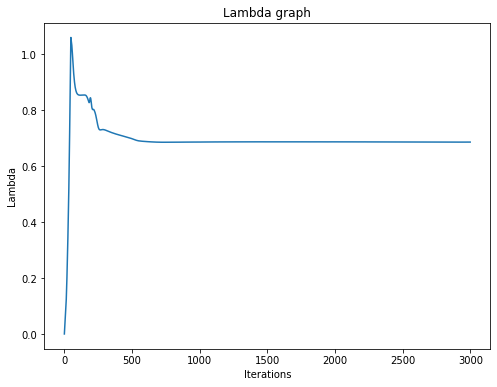

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model2.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [19]:
noise3 = 0.05        
u_train3 = u_train + noise3*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_3 = q_ + noise3*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

In [20]:
q_t_3= tf.convert_to_tensor(q_3,dtype=tf.float32)

In [21]:
model3 = PhysicsInformedNN3(X_u_train, u_train3, layers1, lb1, ub1 , q_t_3)
model3.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 2.738e+00, Lambda_1: 0.000, Lambda_2: 1.000000, Time: 0.53
It: 10, Loss: 2.032e+00, Lambda_1: 0.006, Lambda_2: 1.000000, Time: 0.16
It: 20, Loss: 1.502e+00, Lambda_1: 0.012, Lambda_2: 1.000000, Time: 0.13
It: 30, Loss: 1.130e+00, Lambda_1: 0.017, Lambda_2: 1.000000, Time: 0.14
It: 40, Loss: 8.863e-01, Lambda_1: 0.023, Lambda_2: 1.000000, Time: 0.16
It: 50, Loss: 7.390e-01, Lambda_1: 0.031, Lambda_2: 1.000000, Time: 0.20
It: 60, Loss: 6.585e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.10
It: 70, Loss: 6.199e-01, Lambda_1: 0.060, Lambda_2: 1.000000, Time: 0.11
It: 80, Loss: 6.043e-01, Lambda_1: 0

It: 1070, Loss: 2.295e-01, Lambda_1: 1.316, Lambda_2: 1.000000, Time: 0.12
It: 1080, Loss: 2.288e-01, Lambda_1: 1.302, Lambda_2: 1.000000, Time: 0.11
It: 1090, Loss: 2.281e-01, Lambda_1: 1.287, Lambda_2: 1.000000, Time: 0.12
It: 1100, Loss: 2.274e-01, Lambda_1: 1.274, Lambda_2: 1.000000, Time: 0.11
It: 1110, Loss: 2.267e-01, Lambda_1: 1.260, Lambda_2: 1.000000, Time: 0.12
It: 1120, Loss: 2.260e-01, Lambda_1: 1.246, Lambda_2: 1.000000, Time: 0.11
It: 1130, Loss: 2.253e-01, Lambda_1: 1.233, Lambda_2: 1.000000, Time: 0.13
It: 1140, Loss: 2.247e-01, Lambda_1: 1.219, Lambda_2: 1.000000, Time: 0.10
It: 1150, Loss: 2.240e-01, Lambda_1: 1.206, Lambda_2: 1.000000, Time: 0.12
It: 1160, Loss: 2.233e-01, Lambda_1: 1.194, Lambda_2: 1.000000, Time: 0.11
It: 1170, Loss: 2.226e-01, Lambda_1: 1.181, Lambda_2: 1.000000, Time: 0.12
It: 1180, Loss: 2.219e-01, Lambda_1: 1.169, Lambda_2: 1.000000, Time: 0.11
It: 1190, Loss: 2.212e-01, Lambda_1: 1.156, Lambda_2: 1.000000, Time: 0.13
It: 1200, Loss: 2.205e-01

It: 2170, Loss: 2.510e-02, Lambda_1: 0.810, Lambda_2: 1.000000, Time: 0.11
It: 2180, Loss: 2.470e-02, Lambda_1: 0.808, Lambda_2: 1.000000, Time: 0.11
It: 2190, Loss: 2.432e-02, Lambda_1: 0.806, Lambda_2: 1.000000, Time: 0.12
It: 2200, Loss: 2.396e-02, Lambda_1: 0.803, Lambda_2: 1.000000, Time: 0.11
It: 2210, Loss: 2.448e-02, Lambda_1: 0.801, Lambda_2: 1.000000, Time: 0.13
It: 2220, Loss: 2.329e-02, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.10
It: 2230, Loss: 2.306e-02, Lambda_1: 0.796, Lambda_2: 1.000000, Time: 0.11
It: 2240, Loss: 2.274e-02, Lambda_1: 0.794, Lambda_2: 1.000000, Time: 0.11
It: 2250, Loss: 2.242e-02, Lambda_1: 0.792, Lambda_2: 1.000000, Time: 0.13
It: 2260, Loss: 2.215e-02, Lambda_1: 0.790, Lambda_2: 1.000000, Time: 0.10
It: 2270, Loss: 2.189e-02, Lambda_1: 0.788, Lambda_2: 1.000000, Time: 0.12
It: 2280, Loss: 2.164e-02, Lambda_1: 0.786, Lambda_2: 1.000000, Time: 0.11
It: 2290, Loss: 2.139e-02, Lambda_1: 0.785, Lambda_2: 1.000000, Time: 0.12
It: 2300, Loss: 2.115e-02

It: 3270, Loss: 1.132e-02, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.12
It: 3280, Loss: 1.130e-02, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.10
It: 3290, Loss: 1.128e-02, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.11
It: 3300, Loss: 1.126e-02, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.10
It: 3310, Loss: 1.124e-02, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.12
It: 3320, Loss: 1.122e-02, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.11
It: 3330, Loss: 1.120e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.12
It: 3340, Loss: 1.123e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.10
It: 3350, Loss: 1.126e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.13
It: 3360, Loss: 1.119e-02, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.12
It: 3370, Loss: 1.113e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.14
It: 3380, Loss: 1.111e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.11
It: 3390, Loss: 1.109e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.12
It: 3400, Loss: 1.107e-02

It: 4370, Loss: 9.689e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 4380, Loss: 9.762e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 4390, Loss: 9.655e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 4400, Loss: 9.631e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 4410, Loss: 9.623e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 4420, Loss: 9.611e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 4430, Loss: 9.599e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4440, Loss: 9.588e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4450, Loss: 9.577e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4460, Loss: 9.566e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4470, Loss: 9.555e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 9.545e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 4490, Loss: 9.534e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4500, Loss: 9.524e-03

It: 5480, Loss: 8.702e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 5490, Loss: 8.693e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 5500, Loss: 8.687e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 5510, Loss: 8.681e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 5520, Loss: 8.675e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 5530, Loss: 8.669e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 5540, Loss: 8.664e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.09
It: 5550, Loss: 8.658e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.09
It: 5560, Loss: 8.652e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 5570, Loss: 8.647e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 5580, Loss: 8.641e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 5590, Loss: 8.636e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 5600, Loss: 8.631e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 5610, Loss: 8.629e-03

It: 6590, Loss: 8.339e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6600, Loss: 8.336e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 6610, Loss: 8.334e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6620, Loss: 8.332e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 6630, Loss: 8.330e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6640, Loss: 8.329e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6650, Loss: 8.328e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6660, Loss: 8.326e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 6670, Loss: 8.325e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 6680, Loss: 8.324e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6690, Loss: 8.338e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6700, Loss: 8.610e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 6710, Loss: 8.353e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 6720, Loss: 8.325e-03

It: 7690, Loss: 8.246e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 7700, Loss: 8.240e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 7710, Loss: 8.235e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 7720, Loss: 8.234e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 7730, Loss: 8.233e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 7740, Loss: 8.232e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 7750, Loss: 8.231e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 7760, Loss: 8.231e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 7770, Loss: 8.230e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 7780, Loss: 8.229e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 7790, Loss: 8.229e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 7800, Loss: 8.228e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 7810, Loss: 8.228e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 7820, Loss: 8.362e-03

It: 8790, Loss: 8.200e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8800, Loss: 8.178e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8810, Loss: 8.180e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 8820, Loss: 8.181e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 8830, Loss: 8.190e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8840, Loss: 8.306e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 8850, Loss: 8.194e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8860, Loss: 8.179e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8870, Loss: 8.175e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 8880, Loss: 8.176e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8890, Loss: 8.173e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8900, Loss: 8.173e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 8910, Loss: 8.180e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 8920, Loss: 8.299e-03

It: 9890, Loss: 8.557e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 9900, Loss: 8.152e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 9910, Loss: 8.171e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 9920, Loss: 8.132e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 9930, Loss: 8.135e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 9940, Loss: 8.130e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 9950, Loss: 8.130e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 9960, Loss: 8.130e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 9970, Loss: 8.129e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 9980, Loss: 8.129e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 9990, Loss: 8.128e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 10000, Loss: 8.128e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 10010, Loss: 8.127e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 10020, Loss: 8.127e

It: 10970, Loss: 8.092e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 10980, Loss: 8.092e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 10990, Loss: 8.110e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 11000, Loss: 8.397e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 11010, Loss: 8.095e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 11020, Loss: 8.123e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 11030, Loss: 8.092e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 11040, Loss: 8.094e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.10
It: 11050, Loss: 8.090e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 11060, Loss: 8.089e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 11070, Loss: 8.089e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 11080, Loss: 8.088e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 11090, Loss: 8.088e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 11100, L

It: 12050, Loss: 8.054e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 12060, Loss: 8.054e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 12070, Loss: 8.053e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 12080, Loss: 8.054e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 12090, Loss: 8.152e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 12100, Loss: 8.063e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 12110, Loss: 8.114e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 12120, Loss: 8.054e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 12130, Loss: 8.060e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 12140, Loss: 8.052e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 12150, Loss: 8.051e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 12160, Loss: 8.051e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.11
It: 12170, Loss: 8.050e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.12
It: 12180, L

It: 13130, Loss: 8.025e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 13140, Loss: 8.380e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.10
It: 13150, Loss: 8.107e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 13160, Loss: 8.018e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 13170, Loss: 8.029e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 13180, Loss: 8.017e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 13190, Loss: 8.015e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 13200, Loss: 8.014e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 13210, Loss: 8.014e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 13220, Loss: 8.014e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 13230, Loss: 8.013e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 13240, Loss: 8.013e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.10
It: 13250, Loss: 8.013e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 13260, L

It: 14210, Loss: 7.980e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 14220, Loss: 7.982e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 14230, Loss: 8.015e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 14240, Loss: 8.091e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 14250, Loss: 8.021e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 14260, Loss: 7.994e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.10
It: 14270, Loss: 7.984e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 14280, Loss: 7.978e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.10
It: 14290, Loss: 7.977e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 14300, Loss: 7.976e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.10
It: 14310, Loss: 7.976e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 14320, Loss: 7.993e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.10
It: 14330, Loss: 8.224e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 14340, L

It: 15290, Loss: 8.059e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 15300, Loss: 7.945e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 15310, Loss: 7.964e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 15320, Loss: 7.951e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 15330, Loss: 7.943e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 15340, Loss: 7.942e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 15350, Loss: 7.942e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 15360, Loss: 7.941e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 15370, Loss: 7.941e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 15380, Loss: 7.940e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 15390, Loss: 7.941e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 15400, Loss: 7.960e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.11
It: 15410, Loss: 8.124e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 15420, L

It: 16370, Loss: 7.915e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 16380, Loss: 7.928e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 16390, Loss: 7.944e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 16400, Loss: 7.928e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 16410, Loss: 7.911e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 16420, Loss: 7.910e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 16430, Loss: 7.924e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 16440, Loss: 8.094e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 16450, Loss: 7.988e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 16460, Loss: 7.935e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.13
It: 16470, Loss: 7.918e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 16480, Loss: 7.912e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 16490, Loss: 7.907e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 16500, L

It: 17450, Loss: 7.894e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 17460, Loss: 7.900e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 17470, Loss: 7.907e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.15
It: 17480, Loss: 7.891e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 17490, Loss: 7.886e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 17500, Loss: 7.911e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 17510, Loss: 7.927e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.15
It: 17520, Loss: 7.890e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.14
It: 17530, Loss: 7.889e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 17540, Loss: 7.877e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 17550, Loss: 7.878e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 17560, Loss: 7.927e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 17570, Loss: 7.891e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 17580, L

It: 18540, Loss: 7.857e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 18550, Loss: 7.866e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 18560, Loss: 7.907e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 18570, Loss: 7.848e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 18580, Loss: 7.866e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 18590, Loss: 7.878e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 18600, Loss: 7.859e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 18610, Loss: 7.854e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 18620, Loss: 7.886e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.18
It: 18630, Loss: 7.871e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 18640, Loss: 7.859e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.18
It: 18650, Loss: 7.864e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 18660, Loss: 7.857e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 18670, L

It: 19630, Loss: 7.818e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 19640, Loss: 7.855e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19650, Loss: 7.826e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19660, Loss: 7.857e-03, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 19670, Loss: 7.821e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 19680, Loss: 7.826e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19690, Loss: 7.814e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19700, Loss: 7.840e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19710, Loss: 7.833e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 19720, Loss: 7.845e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 19730, Loss: 7.811e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19740, Loss: 7.834e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 19750, Loss: 7.839e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 19760, L

It: 20710, Loss: 7.793e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 20720, Loss: 7.788e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 20730, Loss: 7.793e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 20740, Loss: 7.792e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 20750, Loss: 7.783e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 20760, Loss: 7.792e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 20770, Loss: 7.796e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 20780, Loss: 7.776e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 20790, Loss: 7.785e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 20800, Loss: 7.812e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 20810, Loss: 7.769e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 20820, Loss: 7.774e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 20830, Loss: 7.848e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 20840, L

It: 21790, Loss: 7.754e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 21800, Loss: 7.730e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 21810, Loss: 7.729e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 21820, Loss: 7.753e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 21830, Loss: 7.725e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 21840, Loss: 7.743e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 21850, Loss: 7.738e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 21860, Loss: 7.734e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 21870, Loss: 7.748e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 21880, Loss: 7.735e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 21890, Loss: 7.730e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 21900, Loss: 7.759e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 21910, Loss: 7.729e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 21920, L

It: 22870, Loss: 7.696e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 22880, Loss: 7.698e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 22890, Loss: 7.717e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 22900, Loss: 7.690e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.12
It: 22910, Loss: 7.689e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 22920, Loss: 7.741e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 22930, Loss: 7.683e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 22940, Loss: 7.695e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 22950, Loss: 7.722e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 22960, Loss: 7.682e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 22970, Loss: 7.681e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 22980, Loss: 7.682e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 22990, Loss: 7.833e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 23000, L

It: 23950, Loss: 7.664e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 23960, Loss: 7.664e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 23970, Loss: 7.664e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 23980, Loss: 7.664e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 23990, Loss: 7.664e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 24000, Loss: 7.663e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.13
It: 24010, Loss: 7.663e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 24020, Loss: 7.663e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 24030, Loss: 7.663e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.14
It: 24040, Loss: 7.663e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 24050, Loss: 7.662e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 24060, Loss: 7.662e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 24070, Loss: 7.662e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 24080, L

It: 25040, Loss: 7.645e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 25050, Loss: 7.651e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 25060, Loss: 7.658e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 25070, Loss: 7.646e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 25080, Loss: 7.652e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 25090, Loss: 7.691e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 25100, Loss: 7.640e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 25110, Loss: 7.668e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 25120, Loss: 7.643e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 25130, Loss: 7.644e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 25140, Loss: 7.682e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 25150, Loss: 7.647e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 25160, Loss: 7.655e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 25170, L

It: 26120, Loss: 7.684e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 26130, Loss: 7.626e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 26140, Loss: 7.617e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 26150, Loss: 7.617e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 26160, Loss: 7.621e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 26170, Loss: 7.623e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 26180, Loss: 7.618e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 26190, Loss: 7.617e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 26200, Loss: 7.634e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 26210, Loss: 7.651e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 26220, Loss: 7.664e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 26230, Loss: 7.627e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.26
It: 26240, Loss: 7.619e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 26250, L

It: 27200, Loss: 7.625e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 27210, Loss: 7.593e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.24
It: 27220, Loss: 7.616e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 27230, Loss: 7.604e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 27240, Loss: 7.604e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 27250, Loss: 7.623e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 27260, Loss: 7.602e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 27270, Loss: 7.596e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 27280, Loss: 7.625e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 27290, Loss: 7.604e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 27300, Loss: 7.610e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 27310, Loss: 7.604e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 27320, Loss: 7.599e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.22
It: 27330, L

It: 28290, Loss: 1.353e-02, Lambda_1: 0.702, Lambda_2: 1.000000, Time: 0.18
It: 28300, Loss: 1.064e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.16
It: 28310, Loss: 9.253e-03, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.16
It: 28320, Loss: 8.940e-03, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.16
It: 28330, Loss: 8.761e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.15
It: 28340, Loss: 8.660e-03, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.16
It: 28350, Loss: 8.575e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.15
It: 28360, Loss: 8.509e-03, Lambda_1: 0.702, Lambda_2: 1.000000, Time: 0.16
It: 28370, Loss: 8.456e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.16
It: 28380, Loss: 8.412e-03, Lambda_1: 0.699, Lambda_2: 1.000000, Time: 0.16
It: 28390, Loss: 8.374e-03, Lambda_1: 0.698, Lambda_2: 1.000000, Time: 0.18
It: 28400, Loss: 8.341e-03, Lambda_1: 0.696, Lambda_2: 1.000000, Time: 0.16
It: 28410, Loss: 8.312e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.16
It: 28420, L

It: 29370, Loss: 7.740e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29380, Loss: 7.738e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29390, Loss: 7.737e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29400, Loss: 7.736e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.17
It: 29410, Loss: 7.735e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29420, Loss: 7.733e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29430, Loss: 7.732e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29440, Loss: 7.731e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.17
It: 29450, Loss: 7.730e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29460, Loss: 7.729e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 29470, Loss: 7.727e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.19
It: 29480, Loss: 7.726e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.20
It: 29490, Loss: 7.725e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.19
It: 29500, L

In [22]:
np_loss_array_3=np.array(model3.loss_array)

In [23]:
with h5py.File('loss_array_3.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_3)

In [24]:
np_lambda_array_3 = np.array(model3.lambda_array)

In [25]:
with h5py.File('lambda_array_3.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_3)

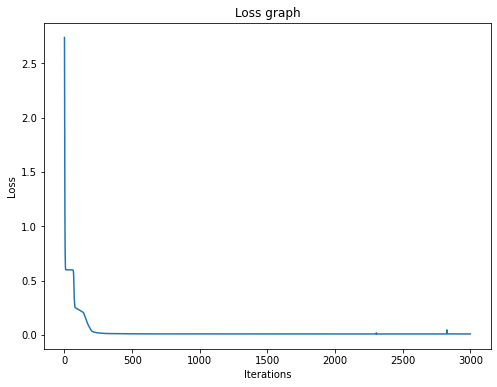

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model3.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

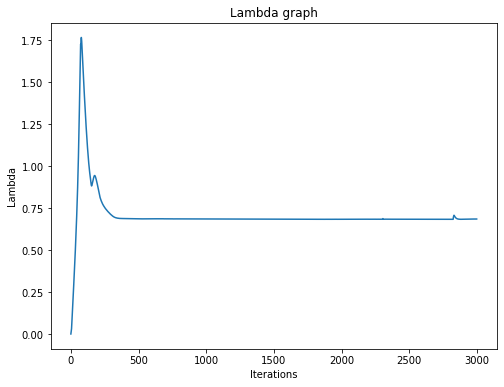

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model3.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [31]:
noise4 = 0.10       
u_train4 = u_train + noise4*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_4 = q_ + noise4*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

In [32]:
q_t_4= tf.convert_to_tensor(q_4,dtype=tf.float32)

In [33]:
model4 = PhysicsInformedNN3(X_u_train, u_train4, layers1, lb1, ub1 , q_t_4)
model4.train(30000)

Device mapping:

It: 0, Loss: 6.713e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.60
It: 10, Loss: 6.011e-01, Lambda_1: 0.009, Lambda_2: 1.000000, Time: 0.14
It: 20, Loss: 6.053e-01, Lambda_1: 0.019, Lambda_2: 1.000000, Time: 0.11
It: 30, Loss: 6.007e-01, Lambda_1: 0.028, Lambda_2: 1.000000, Time: 0.12
It: 40, Loss: 6.007e-01, Lambda_1: 0.036, Lambda_2: 1.000000, Time: 0.09
It: 50, Loss: 6.003e-01, Lambda_1: 0.043, Lambda_2: 1.000000, Time: 0.10
It: 60, Loss: 6.003e-01, Lambda_1: 0.049, Lambda_2: 1.000000, Time: 0.10
It: 70, Loss: 6.002e-01, Lambda_1: 0.054, Lambda_2: 1.000000, Time: 0.10
It: 80, Loss: 6.002e-01, Lambda_1: 0.058, Lambda_2: 1.000000, Time: 0.11
It: 90, Loss: 6.002e-01, Lambda_1: 0.064, Lambda_2: 1.000000, Time: 0.11
It: 100, Loss: 6.002e-01, Lambda_1: 0.073, Lambda_2: 1.000000, Time: 0.10
It: 110, Loss: 6.002e-01, Lambda_1: 0.085, Lambda_2: 1.000000, Time: 0.10
It: 120, Loss: 6.002e-01, Lambda_1: 0.099, Lambda_2: 1.000000, Time: 0.13
It: 130, Loss: 6.002e-01, Lambda

It: 1120, Loss: 2.264e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 1130, Loss: 2.264e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.10
It: 1140, Loss: 2.264e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 1150, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 1160, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.13
It: 1170, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 1180, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 1190, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 1200, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 1210, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.10
It: 1220, Loss: 2.263e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 1230, Loss: 2.262e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 1240, Loss: 2.262e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 1250, Loss: 2.262e-01

It: 2230, Loss: 1.924e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 2240, Loss: 1.898e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 2250, Loss: 1.865e-01, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.10
It: 2260, Loss: 1.820e-01, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.11
It: 2270, Loss: 1.742e-01, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.11
It: 2280, Loss: 1.667e-01, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.12
It: 2290, Loss: 1.629e-01, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.11
It: 2300, Loss: 1.585e-01, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.12
It: 2310, Loss: 1.543e-01, Lambda_1: 0.854, Lambda_2: 1.000000, Time: 0.11
It: 2320, Loss: 1.499e-01, Lambda_1: 0.850, Lambda_2: 1.000000, Time: 0.11
It: 2330, Loss: 1.452e-01, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.12
It: 2340, Loss: 1.407e-01, Lambda_1: 0.842, Lambda_2: 1.000000, Time: 0.10
It: 2350, Loss: 1.361e-01, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.11
It: 2360, Loss: 1.319e-01

It: 3340, Loss: 8.439e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.11
It: 3350, Loss: 8.433e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.12
It: 3360, Loss: 8.429e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.11
It: 3370, Loss: 8.436e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.11
It: 3380, Loss: 8.415e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.10
It: 3390, Loss: 8.412e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.11
It: 3400, Loss: 8.403e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.11
It: 3410, Loss: 8.398e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.10
It: 3420, Loss: 8.401e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.10
It: 3430, Loss: 8.385e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.12
It: 3440, Loss: 8.381e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.12
It: 3450, Loss: 8.374e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 3460, Loss: 8.366e-02, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.11
It: 3470, Loss: 8.364e-02

It: 4450, Loss: 6.543e-02, Lambda_1: 0.792, Lambda_2: 1.000000, Time: 0.10
It: 4460, Loss: 6.473e-02, Lambda_1: 0.791, Lambda_2: 1.000000, Time: 0.10
It: 4470, Loss: 6.396e-02, Lambda_1: 0.789, Lambda_2: 1.000000, Time: 0.11
It: 4480, Loss: 6.310e-02, Lambda_1: 0.788, Lambda_2: 1.000000, Time: 0.12
It: 4490, Loss: 6.216e-02, Lambda_1: 0.786, Lambda_2: 1.000000, Time: 0.12
It: 4500, Loss: 6.114e-02, Lambda_1: 0.784, Lambda_2: 1.000000, Time: 0.11
It: 4510, Loss: 6.001e-02, Lambda_1: 0.782, Lambda_2: 1.000000, Time: 0.10
It: 4520, Loss: 5.875e-02, Lambda_1: 0.780, Lambda_2: 1.000000, Time: 0.12
It: 4530, Loss: 5.735e-02, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.11
It: 4540, Loss: 5.616e-02, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.11
It: 4550, Loss: 5.403e-02, Lambda_1: 0.771, Lambda_2: 1.000000, Time: 0.12
It: 4560, Loss: 5.217e-02, Lambda_1: 0.767, Lambda_2: 1.000000, Time: 0.12
It: 4570, Loss: 5.003e-02, Lambda_1: 0.764, Lambda_2: 1.000000, Time: 0.13
It: 4580, Loss: 4.778e-02

It: 5560, Loss: 1.545e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5570, Loss: 1.543e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.09
It: 5580, Loss: 1.541e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.10
It: 5590, Loss: 1.540e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5600, Loss: 1.538e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.13
It: 5610, Loss: 1.539e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.10
It: 5620, Loss: 1.576e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5630, Loss: 1.538e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.11
It: 5640, Loss: 1.531e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5650, Loss: 1.533e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5660, Loss: 1.528e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.11
It: 5670, Loss: 1.529e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5680, Loss: 1.547e-02, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.12
It: 5690, Loss: 1.525e-02

It: 6660, Loss: 1.441e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.12
It: 6670, Loss: 1.441e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.11
It: 6680, Loss: 1.441e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.13
It: 6690, Loss: 1.486e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.12
It: 6700, Loss: 1.448e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.12
It: 6710, Loss: 1.441e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.11
It: 6720, Loss: 1.438e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.12
It: 6730, Loss: 1.439e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.11
It: 6740, Loss: 1.437e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.13
It: 6750, Loss: 1.438e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.11
It: 6760, Loss: 1.448e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.12
It: 6770, Loss: 1.446e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.11
It: 6780, Loss: 1.436e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.13
It: 6790, Loss: 1.442e-02

It: 7760, Loss: 1.388e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.13
It: 7770, Loss: 1.387e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.14
It: 7780, Loss: 1.387e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.14
It: 7790, Loss: 1.389e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.13
It: 7800, Loss: 1.388e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.12
It: 7810, Loss: 1.385e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.13
It: 7820, Loss: 1.385e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.15
It: 7830, Loss: 1.387e-02, Lambda_1: 0.717, Lambda_2: 1.000000, Time: 0.14
It: 7840, Loss: 1.414e-02, Lambda_1: 0.716, Lambda_2: 1.000000, Time: 0.13
It: 7850, Loss: 1.383e-02, Lambda_1: 0.716, Lambda_2: 1.000000, Time: 0.13
It: 7860, Loss: 1.388e-02, Lambda_1: 0.716, Lambda_2: 1.000000, Time: 0.15
It: 7870, Loss: 1.382e-02, Lambda_1: 0.716, Lambda_2: 1.000000, Time: 0.13
It: 7880, Loss: 1.384e-02, Lambda_1: 0.716, Lambda_2: 1.000000, Time: 0.13
It: 7890, Loss: 1.406e-02

It: 8860, Loss: 1.325e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.14
It: 8870, Loss: 1.343e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.14
It: 8880, Loss: 1.318e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.15
It: 8890, Loss: 1.324e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.13
It: 8900, Loss: 1.321e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.13
It: 8910, Loss: 1.320e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.12
It: 8920, Loss: 1.327e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.13
It: 8930, Loss: 1.322e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.13
It: 8940, Loss: 1.313e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.14
It: 8950, Loss: 1.316e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.14
It: 8960, Loss: 1.343e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.14
It: 8970, Loss: 1.312e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.14
It: 8980, Loss: 1.315e-02, Lambda_1: 0.705, Lambda_2: 1.000000, Time: 0.14
It: 8990, Loss: 1.309e-02

It: 9960, Loss: 1.220e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.14
It: 9970, Loss: 1.218e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.14
It: 9980, Loss: 1.217e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.16
It: 9990, Loss: 1.216e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.17
It: 10000, Loss: 1.215e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.14
It: 10010, Loss: 1.215e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.16
It: 10020, Loss: 1.222e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.15
It: 10030, Loss: 1.230e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.14
It: 10040, Loss: 1.222e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.16
It: 10050, Loss: 1.211e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.14
It: 10060, Loss: 1.214e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.14
It: 10070, Loss: 1.222e-02, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.14
It: 10080, Loss: 1.212e-02, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.14
It: 10090, Loss:

It: 11040, Loss: 1.166e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 11050, Loss: 1.153e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 11060, Loss: 1.157e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 11070, Loss: 1.155e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 11080, Loss: 1.156e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 11090, Loss: 1.165e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.23
It: 11100, Loss: 1.154e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.16
It: 11110, Loss: 1.151e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 11120, Loss: 1.156e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.17
It: 11130, Loss: 1.178e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 11140, Loss: 1.155e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.17
It: 11150, Loss: 1.152e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 11160, Loss: 1.149e-02, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 11170, L

It: 12130, Loss: 1.122e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 12140, Loss: 1.124e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.20
It: 12150, Loss: 1.139e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 12160, Loss: 1.123e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 12170, Loss: 1.125e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 12180, Loss: 1.130e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.19
It: 12190, Loss: 1.126e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 12200, Loss: 1.122e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 12210, Loss: 1.127e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 12220, Loss: 1.142e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 12230, Loss: 1.121e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 12240, Loss: 1.127e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 12250, Loss: 1.124e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.21
It: 12260, L

It: 13210, Loss: 1.111e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 13220, Loss: 1.104e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 13230, Loss: 1.111e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.22
It: 13240, Loss: 1.124e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 13250, Loss: 1.107e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 13260, Loss: 1.110e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 13270, Loss: 1.106e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 13280, Loss: 1.110e-02, Lambda_1: 0.683, Lambda_2: 1.000000, Time: 0.23
It: 13290, Loss: 1.121e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.23
It: 13300, Loss: 1.103e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.23
It: 13310, Loss: 1.110e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 13320, Loss: 1.116e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.31
It: 13330, Loss: 1.103e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.29
It: 13340, L

It: 14290, Loss: 1.108e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.29
It: 14300, Loss: 1.094e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.28
It: 14310, Loss: 1.093e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 14320, Loss: 1.106e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.26
It: 14330, Loss: 1.099e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.26
It: 14340, Loss: 1.101e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.26
It: 14350, Loss: 1.093e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.28
It: 14360, Loss: 1.093e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 14370, Loss: 1.110e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.25
It: 14380, Loss: 1.095e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.24
It: 14390, Loss: 1.100e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 14400, Loss: 1.093e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 14410, Loss: 1.092e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 14420, L

It: 15370, Loss: 1.089e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 15380, Loss: 1.101e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 15390, Loss: 1.088e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 15400, Loss: 1.086e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 15410, Loss: 1.101e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 15420, Loss: 1.089e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 15430, Loss: 1.091e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 15440, Loss: 1.090e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 15450, Loss: 1.090e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 15460, Loss: 1.096e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 15470, Loss: 1.091e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 15480, Loss: 1.085e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 15490, Loss: 1.085e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 15500, L

It: 16460, Loss: 1.090e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 16470, Loss: 1.088e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.23
It: 16480, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 16490, Loss: 1.087e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 16500, Loss: 1.086e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 16510, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 16520, Loss: 1.089e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 16530, Loss: 1.090e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 16540, Loss: 1.080e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 16550, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 16560, Loss: 1.109e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 16570, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 16580, Loss: 1.082e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 16590, L

It: 17540, Loss: 1.118e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17550, Loss: 1.097e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17560, Loss: 1.101e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 17570, Loss: 1.104e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 17580, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17590, Loss: 1.076e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 17600, Loss: 1.077e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17610, Loss: 1.076e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17620, Loss: 1.075e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17630, Loss: 1.075e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17640, Loss: 1.075e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17650, Loss: 1.076e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 17660, Loss: 1.091e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 17670, L

It: 18620, Loss: 1.088e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18630, Loss: 1.112e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 18640, Loss: 1.078e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 18650, Loss: 1.077e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 18660, Loss: 1.074e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 18670, Loss: 1.072e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18680, Loss: 1.072e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18690, Loss: 1.072e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18700, Loss: 1.071e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18710, Loss: 1.071e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18720, Loss: 1.074e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 18730, Loss: 1.101e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 18740, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 18750, L

It: 19700, Loss: 1.084e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 19710, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 19720, Loss: 1.074e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 19730, Loss: 1.076e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 19740, Loss: 1.071e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 19750, Loss: 1.070e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 19760, Loss: 1.091e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 19770, Loss: 1.068e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 19780, Loss: 1.072e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 19790, Loss: 1.068e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 19800, Loss: 1.071e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 19810, Loss: 1.100e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 19820, Loss: 1.079e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 19830, L

It: 20780, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20790, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20800, Loss: 1.072e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20810, Loss: 1.070e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20820, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20830, Loss: 1.076e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20840, Loss: 1.070e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 20850, Loss: 1.066e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20860, Loss: 1.078e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20870, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 20880, Loss: 1.070e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 20890, Loss: 1.067e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.23
It: 20900, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 20910, L

It: 21870, Loss: 1.082e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 21880, Loss: 1.068e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 21890, Loss: 1.062e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 21900, Loss: 1.068e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 21910, Loss: 1.073e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21920, Loss: 1.062e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 21930, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.21
It: 21940, Loss: 1.070e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 21950, Loss: 1.062e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21960, Loss: 1.069e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 21970, Loss: 1.075e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 21980, Loss: 1.066e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 21990, Loss: 1.063e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 22000, L

It: 22950, Loss: 1.083e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 22960, Loss: 1.060e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 22970, Loss: 1.060e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 22980, Loss: 1.062e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 22990, Loss: 1.072e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 23000, Loss: 1.059e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 23010, Loss: 1.063e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 23020, Loss: 1.071e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 23030, Loss: 1.059e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 23040, Loss: 1.061e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.22
It: 23050, Loss: 1.081e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 23060, Loss: 1.060e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 23070, Loss: 1.061e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 23080, L

It: 24030, Loss: 1.057e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.23
It: 24040, Loss: 1.056e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.23
It: 24050, Loss: 1.056e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 24060, Loss: 1.111e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 24070, Loss: 1.086e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 24080, Loss: 1.059e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 24090, Loss: 1.056e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 24100, Loss: 1.056e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 24110, Loss: 1.057e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.20
It: 24120, Loss: 1.056e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.18
It: 24130, Loss: 1.061e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 24140, Loss: 1.068e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 24150, Loss: 1.062e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 24160, L

It: 25110, Loss: 1.070e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 25120, Loss: 1.061e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 25130, Loss: 1.056e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.18
It: 25140, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 25150, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 25160, Loss: 1.066e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 25170, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 25180, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 25190, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.18
It: 25200, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 25210, Loss: 1.058e-02, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.19
It: 25220, Loss: 1.064e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.18
It: 25230, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 25240, L

It: 26190, Loss: 1.052e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 26200, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 26210, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 26220, Loss: 1.059e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 26230, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.24
It: 26240, Loss: 1.051e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.23
It: 26250, Loss: 1.060e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 26260, Loss: 1.061e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 26270, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 26280, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.24
It: 26290, Loss: 1.051e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.25
It: 26300, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.24
It: 26310, Loss: 1.067e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 26320, L

It: 27270, Loss: 1.062e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 27280, Loss: 1.055e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 27290, Loss: 1.049e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27300, Loss: 1.049e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27310, Loss: 1.049e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 27320, Loss: 1.048e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 27330, Loss: 1.050e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 27340, Loss: 1.080e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27350, Loss: 1.059e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27360, Loss: 1.053e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27370, Loss: 1.050e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27380, Loss: 1.048e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 27390, Loss: 1.050e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 27400, L

It: 28360, Loss: 1.047e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 28370, Loss: 1.062e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 28380, Loss: 1.046e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 28390, Loss: 1.047e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 28400, Loss: 1.048e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 28410, Loss: 1.047e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 28420, Loss: 1.048e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 28430, Loss: 1.079e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 28440, Loss: 1.053e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 28450, Loss: 1.049e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.17
It: 28460, Loss: 1.046e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.18
It: 28470, Loss: 1.047e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.19
It: 28480, Loss: 1.046e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 28490, L

It: 29440, Loss: 1.044e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 29450, Loss: 1.043e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 29460, Loss: 1.044e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.22
It: 29470, Loss: 1.044e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 29480, Loss: 1.054e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 29490, Loss: 1.046e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 29500, Loss: 1.043e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 29510, Loss: 1.044e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 29520, Loss: 1.044e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 29530, Loss: 1.043e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 29540, Loss: 1.044e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.21
It: 29550, Loss: 1.070e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 29560, Loss: 1.050e-02, Lambda_1: 0.680, Lambda_2: 1.000000, Time: 0.22
It: 29570, L

In [34]:
np_loss_array_4=np.array(model4.loss_array)

In [35]:
with h5py.File('loss_array_4.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_4)

In [36]:
np_lambda_array_4 = np.array(model4.lambda_array)

In [37]:
with h5py.File('lambda_array_4.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_4)

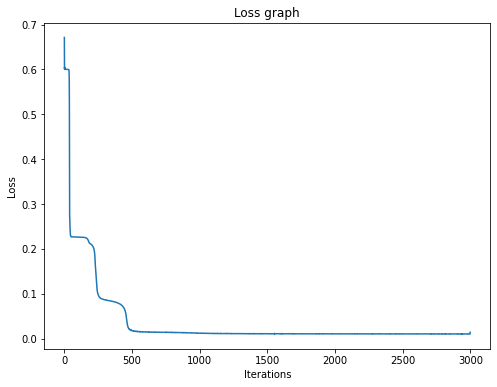

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model4.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

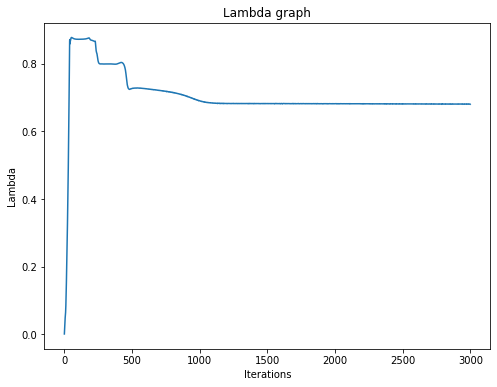

In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model4.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [40]:
noise5 = 0.25       
u_train5 = u_train + noise5*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_5 = q_ + noise5*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

In [41]:
q_t_5= tf.convert_to_tensor(q_5,dtype=tf.float32)

In [42]:
model5 = PhysicsInformedNN3(X_u_train, u_train5, layers1, lb1, ub1 , q_t_5)
model5.train(30000)

Device mapping:

It: 0, Loss: 2.072e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.59
It: 10, Loss: 1.493e+00, Lambda_1: 0.009, Lambda_2: 1.000000, Time: 0.14
It: 20, Loss: 1.089e+00, Lambda_1: 0.019, Lambda_2: 1.000000, Time: 0.13
It: 30, Loss: 8.369e-01, Lambda_1: 0.029, Lambda_2: 1.000000, Time: 0.11
It: 40, Loss: 7.003e-01, Lambda_1: 0.039, Lambda_2: 1.000000, Time: 0.13
It: 50, Loss: 6.389e-01, Lambda_1: 0.049, Lambda_2: 1.000000, Time: 0.12
It: 60, Loss: 6.181e-01, Lambda_1: 0.060, Lambda_2: 1.000000, Time: 0.12
It: 70, Loss: 6.139e-01, Lambda_1: 0.071, Lambda_2: 1.000000, Time: 0.12
It: 80, Loss: 6.138e-01, Lambda_1: 0.083, Lambda_2: 1.000000, Time: 0.10
It: 90, Loss: 6.140e-01, Lambda_1: 0.095, Lambda_2: 1.000000, Time: 0.13
It: 100, Loss: 6.139e-01, Lambda_1: 0.108, Lambda_2: 1.000000, Time: 0.14
It: 110, Loss: 6.138e-01, Lambda_1: 0.120, Lambda_2: 1.000000, Time: 0.11
It: 120, Loss: 6.137e-01, Lambda_1: 0.133, Lambda_2: 1.000000, Time: 0.11
It: 130, Loss: 6.137e-01, Lambda

It: 1120, Loss: 2.382e-01, Lambda_1: 1.006, Lambda_2: 1.000000, Time: 0.13
It: 1130, Loss: 2.376e-01, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.12
It: 1140, Loss: 2.371e-01, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.14
It: 1150, Loss: 2.366e-01, Lambda_1: 0.981, Lambda_2: 1.000000, Time: 0.14
It: 1160, Loss: 2.360e-01, Lambda_1: 0.973, Lambda_2: 1.000000, Time: 0.11
It: 1170, Loss: 2.355e-01, Lambda_1: 0.966, Lambda_2: 1.000000, Time: 0.13
It: 1180, Loss: 2.349e-01, Lambda_1: 0.959, Lambda_2: 1.000000, Time: 0.12
It: 1190, Loss: 2.344e-01, Lambda_1: 0.952, Lambda_2: 1.000000, Time: 0.12
It: 1200, Loss: 2.338e-01, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.13
It: 1210, Loss: 2.332e-01, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.13
It: 1220, Loss: 2.326e-01, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.11
It: 1230, Loss: 2.320e-01, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.11
It: 1240, Loss: 2.313e-01, Lambda_1: 0.923, Lambda_2: 1.000000, Time: 0.13
It: 1250, Loss: 2.307e-01

It: 2220, Loss: 8.310e-02, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.13
It: 2230, Loss: 8.230e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.13
It: 2240, Loss: 8.162e-02, Lambda_1: 0.823, Lambda_2: 1.000000, Time: 0.14
It: 2250, Loss: 8.085e-02, Lambda_1: 0.819, Lambda_2: 1.000000, Time: 0.14
It: 2260, Loss: 8.021e-02, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.13
It: 2270, Loss: 7.955e-02, Lambda_1: 0.813, Lambda_2: 1.000000, Time: 0.11
It: 2280, Loss: 7.913e-02, Lambda_1: 0.810, Lambda_2: 1.000000, Time: 0.11
It: 2290, Loss: 7.835e-02, Lambda_1: 0.807, Lambda_2: 1.000000, Time: 0.13
It: 2300, Loss: 7.774e-02, Lambda_1: 0.804, Lambda_2: 1.000000, Time: 0.11
It: 2310, Loss: 7.717e-02, Lambda_1: 0.801, Lambda_2: 1.000000, Time: 0.12
It: 2320, Loss: 7.662e-02, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.14
It: 2330, Loss: 7.602e-02, Lambda_1: 0.795, Lambda_2: 1.000000, Time: 0.11
It: 2340, Loss: 7.560e-02, Lambda_1: 0.793, Lambda_2: 1.000000, Time: 0.11
It: 2350, Loss: 7.491e-02

It: 3320, Loss: 3.965e-02, Lambda_1: 0.715, Lambda_2: 1.000000, Time: 0.12
It: 3330, Loss: 3.915e-02, Lambda_1: 0.715, Lambda_2: 1.000000, Time: 0.13
It: 3340, Loss: 3.931e-02, Lambda_1: 0.715, Lambda_2: 1.000000, Time: 0.12
It: 3350, Loss: 3.903e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.11
It: 3360, Loss: 3.877e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.13
It: 3370, Loss: 3.907e-02, Lambda_1: 0.713, Lambda_2: 1.000000, Time: 0.13
It: 3380, Loss: 3.860e-02, Lambda_1: 0.713, Lambda_2: 1.000000, Time: 0.12
It: 3390, Loss: 3.860e-02, Lambda_1: 0.713, Lambda_2: 1.000000, Time: 0.13
It: 3400, Loss: 3.832e-02, Lambda_1: 0.712, Lambda_2: 1.000000, Time: 0.12
It: 3410, Loss: 3.817e-02, Lambda_1: 0.712, Lambda_2: 1.000000, Time: 0.11
It: 3420, Loss: 3.806e-02, Lambda_1: 0.712, Lambda_2: 1.000000, Time: 0.11
It: 3430, Loss: 3.874e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.12
It: 3440, Loss: 3.818e-02, Lambda_1: 0.711, Lambda_2: 1.000000, Time: 0.12
It: 3450, Loss: 3.820e-02

It: 4420, Loss: 3.299e-02, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.13
It: 4430, Loss: 3.299e-02, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.11
It: 4440, Loss: 3.384e-02, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4450, Loss: 3.294e-02, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4460, Loss: 3.293e-02, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 4470, Loss: 3.292e-02, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 3.294e-02, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.11
It: 4490, Loss: 3.289e-02, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4500, Loss: 3.293e-02, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.12
It: 4510, Loss: 3.293e-02, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.13
It: 4520, Loss: 3.277e-02, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 4530, Loss: 3.274e-02, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.11
It: 4540, Loss: 3.307e-02, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.10
It: 4550, Loss: 3.267e-02

It: 5520, Loss: 3.128e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.12
It: 5530, Loss: 3.090e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.12
It: 5540, Loss: 3.105e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.14
It: 5550, Loss: 3.113e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.12
It: 5560, Loss: 3.089e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.13
It: 5570, Loss: 3.086e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.14
It: 5580, Loss: 3.087e-02, Lambda_1: 0.676, Lambda_2: 1.000000, Time: 0.13
It: 5590, Loss: 3.192e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.14
It: 5600, Loss: 3.105e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.13
It: 5610, Loss: 3.082e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.13
It: 5620, Loss: 3.099e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.12
It: 5630, Loss: 3.084e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.14
It: 5640, Loss: 3.079e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.12
It: 5650, Loss: 3.081e-02

It: 6620, Loss: 3.017e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6630, Loss: 3.017e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.14
It: 6640, Loss: 3.049e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6650, Loss: 3.018e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.12
It: 6660, Loss: 3.016e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6670, Loss: 3.015e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6680, Loss: 3.020e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6690, Loss: 3.014e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6700, Loss: 3.016e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.15
It: 6710, Loss: 3.020e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.14
It: 6720, Loss: 3.039e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 6730, Loss: 3.017e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.14
It: 6740, Loss: 3.013e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.14
It: 6750, Loss: 3.027e-02

It: 7720, Loss: 2.977e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.14
It: 7730, Loss: 3.043e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.13
It: 7740, Loss: 2.993e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.14
It: 7750, Loss: 2.977e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 7760, Loss: 2.979e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.15
It: 7770, Loss: 2.978e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.13
It: 7780, Loss: 2.977e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.15
It: 7790, Loss: 2.978e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.13
It: 7800, Loss: 2.997e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.14
It: 7810, Loss: 2.980e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.12
It: 7820, Loss: 2.977e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.14
It: 7830, Loss: 2.991e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.14
It: 7840, Loss: 2.977e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.13
It: 7850, Loss: 2.972e-02

It: 8830, Loss: 2.976e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 8840, Loss: 2.942e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.14
It: 8850, Loss: 2.958e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.14
It: 8860, Loss: 2.944e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.13
It: 8870, Loss: 2.942e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 8880, Loss: 2.968e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 8890, Loss: 2.942e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 8900, Loss: 2.957e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 8910, Loss: 2.941e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.14
It: 8920, Loss: 2.941e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.17
It: 8930, Loss: 2.969e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.18
It: 8940, Loss: 2.940e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 8950, Loss: 2.955e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 8960, Loss: 2.940e-02

It: 9930, Loss: 2.922e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 9940, Loss: 2.944e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 9950, Loss: 2.920e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 9960, Loss: 2.942e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 9970, Loss: 2.920e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 9980, Loss: 2.940e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 9990, Loss: 2.920e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 10000, Loss: 2.937e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 10010, Loss: 2.920e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 10020, Loss: 2.935e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 10030, Loss: 2.921e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.18
It: 10040, Loss: 2.932e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.17
It: 10050, Loss: 2.922e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.15
It: 10060, Loss: 2.

It: 11010, Loss: 2.921e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.18
It: 11020, Loss: 2.909e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.17
It: 11030, Loss: 2.926e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.21
It: 11040, Loss: 2.909e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.19
It: 11050, Loss: 2.925e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 11060, Loss: 2.914e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.17
It: 11070, Loss: 2.913e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.16
It: 11080, Loss: 2.920e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.18
It: 11090, Loss: 2.908e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.17
It: 11100, Loss: 2.926e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.19
It: 11110, Loss: 2.909e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.17
It: 11120, Loss: 2.922e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.18
It: 11130, Loss: 2.915e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.24
It: 11140, L

It: 12090, Loss: 2.918e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.21
It: 12100, Loss: 2.910e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.21
It: 12110, Loss: 2.899e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.21
It: 12120, Loss: 2.910e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.23
It: 12130, Loss: 2.899e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.23
It: 12140, Loss: 2.918e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.23
It: 12150, Loss: 2.912e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.20
It: 12160, Loss: 2.912e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.19
It: 12170, Loss: 2.908e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.22
It: 12180, Loss: 2.902e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.22
It: 12190, Loss: 2.901e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.23
It: 12200, Loss: 2.909e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.20
It: 12210, Loss: 2.900e-02, Lambda_1: 0.674, Lambda_2: 1.000000, Time: 0.20
It: 12220, L

It: 13170, Loss: 2.893e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.23
It: 13180, Loss: 2.892e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.22
It: 13190, Loss: 2.892e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.23
It: 13200, Loss: 2.894e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.21
It: 13210, Loss: 2.904e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.21
It: 13220, Loss: 2.908e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.22
It: 13230, Loss: 2.895e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.22
It: 13240, Loss: 2.896e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.20
It: 13250, Loss: 2.894e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.20
It: 13260, Loss: 2.891e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.21
It: 13270, Loss: 2.891e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.23
It: 13280, Loss: 2.892e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.23
It: 13290, Loss: 2.891e-02, Lambda_1: 0.673, Lambda_2: 1.000000, Time: 0.19
It: 13300, L

It: 14250, Loss: 2.888e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.24
It: 14260, Loss: 2.889e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.22
It: 14270, Loss: 2.894e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14280, Loss: 2.895e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14290, Loss: 2.888e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.26
It: 14300, Loss: 2.903e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.25
It: 14310, Loss: 2.888e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.22
It: 14320, Loss: 2.892e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14330, Loss: 2.892e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14340, Loss: 2.887e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14350, Loss: 2.886e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.24
It: 14360, Loss: 2.888e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14370, Loss: 2.884e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.23
It: 14380, L

It: 15330, Loss: 2.900e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.23
It: 15340, Loss: 2.899e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 15350, Loss: 2.899e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 15360, Loss: 2.899e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 15370, Loss: 2.898e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.23
It: 15380, Loss: 2.898e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 15390, Loss: 2.897e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 15400, Loss: 2.897e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.19
It: 15410, Loss: 2.897e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.21
It: 15420, Loss: 2.896e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.21
It: 15430, Loss: 2.896e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 15440, Loss: 2.896e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 15450, Loss: 2.895e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 15460, L

It: 16410, Loss: 2.881e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.20
It: 16420, Loss: 2.881e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 16430, Loss: 2.884e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 16440, Loss: 2.884e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 16450, Loss: 2.882e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.22
It: 16460, Loss: 2.885e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.22
It: 16470, Loss: 2.882e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 16480, Loss: 2.881e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 16490, Loss: 2.888e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 16500, Loss: 2.880e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.20
It: 16510, Loss: 2.887e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.22
It: 16520, Loss: 2.880e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.22
It: 16530, Loss: 2.889e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.20
It: 16540, L

It: 17490, Loss: 2.877e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.22
It: 17500, Loss: 2.878e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.22
It: 17510, Loss: 2.880e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.21
It: 17520, Loss: 2.880e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.21
It: 17530, Loss: 2.876e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.22
It: 17540, Loss: 2.883e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.20
It: 17550, Loss: 2.887e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.22
It: 17560, Loss: 2.876e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.22
It: 17570, Loss: 2.881e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.20
It: 17580, Loss: 2.876e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.21
It: 17590, Loss: 2.876e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.21
It: 17600, Loss: 2.879e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.21
It: 17610, Loss: 2.877e-02, Lambda_1: 0.671, Lambda_2: 1.000000, Time: 0.22
It: 17620, L

It: 18570, Loss: 8.880e-02, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.22
It: 18580, Loss: 1.933e-01, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 18590, Loss: 1.553e-01, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.19
It: 18600, Loss: 1.118e-01, Lambda_1: 0.708, Lambda_2: 1.000000, Time: 0.23
It: 18610, Loss: 6.194e-02, Lambda_1: 0.707, Lambda_2: 1.000000, Time: 0.20
It: 18620, Loss: 5.187e-02, Lambda_1: 0.696, Lambda_2: 1.000000, Time: 0.22
It: 18630, Loss: 3.870e-02, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.23
It: 18640, Loss: 3.318e-02, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.20
It: 18650, Loss: 3.165e-02, Lambda_1: 0.681, Lambda_2: 1.000000, Time: 0.20
It: 18660, Loss: 3.071e-02, Lambda_1: 0.675, Lambda_2: 1.000000, Time: 0.20
It: 18670, Loss: 3.029e-02, Lambda_1: 0.672, Lambda_2: 1.000000, Time: 0.21
It: 18680, Loss: 2.995e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 18690, Loss: 2.971e-02, Lambda_1: 0.667, Lambda_2: 1.000000, Time: 0.19
It: 18700, L

It: 19650, Loss: 2.875e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.25
It: 19660, Loss: 2.870e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.25
It: 19670, Loss: 2.873e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.25
It: 19680, Loss: 2.873e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.24
It: 19690, Loss: 2.872e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.23
It: 19700, Loss: 2.874e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.23
It: 19710, Loss: 2.873e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 19720, Loss: 2.872e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 19730, Loss: 2.874e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.23
It: 19740, Loss: 2.874e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 19750, Loss: 2.871e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 19760, Loss: 2.872e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 19770, Loss: 2.877e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.19
It: 19780, L

It: 20730, Loss: 2.867e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.21
It: 20740, Loss: 2.868e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 20750, Loss: 2.869e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 20760, Loss: 2.874e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.19
It: 20770, Loss: 2.870e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 20780, Loss: 2.867e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.19
It: 20790, Loss: 2.874e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.19
It: 20800, Loss: 2.874e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 20810, Loss: 2.870e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.22
It: 20820, Loss: 2.866e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.23
It: 20830, Loss: 2.875e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 20840, Loss: 2.875e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 20850, Loss: 2.868e-02, Lambda_1: 0.670, Lambda_2: 1.000000, Time: 0.20
It: 20860, L

It: 21810, Loss: 2.891e-02, Lambda_1: 0.663, Lambda_2: 1.000000, Time: 0.23
It: 21820, Loss: 2.889e-02, Lambda_1: 0.663, Lambda_2: 1.000000, Time: 0.24
It: 21830, Loss: 2.887e-02, Lambda_1: 0.663, Lambda_2: 1.000000, Time: 0.23
It: 21840, Loss: 2.885e-02, Lambda_1: 0.663, Lambda_2: 1.000000, Time: 0.22
It: 21850, Loss: 2.884e-02, Lambda_1: 0.663, Lambda_2: 1.000000, Time: 0.23
It: 21860, Loss: 2.883e-02, Lambda_1: 0.663, Lambda_2: 1.000000, Time: 0.22
It: 21870, Loss: 2.882e-02, Lambda_1: 0.664, Lambda_2: 1.000000, Time: 0.22
It: 21880, Loss: 2.881e-02, Lambda_1: 0.664, Lambda_2: 1.000000, Time: 0.23
It: 21890, Loss: 2.880e-02, Lambda_1: 0.664, Lambda_2: 1.000000, Time: 0.23
It: 21900, Loss: 2.879e-02, Lambda_1: 0.664, Lambda_2: 1.000000, Time: 0.20
It: 21910, Loss: 2.878e-02, Lambda_1: 0.664, Lambda_2: 1.000000, Time: 0.23
It: 21920, Loss: 2.878e-02, Lambda_1: 0.664, Lambda_2: 1.000000, Time: 0.23
It: 21930, Loss: 2.877e-02, Lambda_1: 0.665, Lambda_2: 1.000000, Time: 0.23
It: 21940, L

It: 22890, Loss: 2.864e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 22900, Loss: 2.867e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.19
It: 22910, Loss: 2.864e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 22920, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 22930, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 22940, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 22950, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 22960, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.23
It: 22970, Loss: 2.874e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 22980, Loss: 2.887e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 22990, Loss: 2.864e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 23000, Loss: 2.864e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 23010, Loss: 2.865e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 23020, L

It: 23970, Loss: 2.862e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 23980, Loss: 2.866e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 23990, Loss: 2.862e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 24000, Loss: 2.860e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 24010, Loss: 2.860e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 24020, Loss: 2.859e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 24030, Loss: 2.859e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 24040, Loss: 2.860e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 24050, Loss: 2.860e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 24060, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 24070, Loss: 2.863e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 24080, Loss: 2.860e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.23
It: 24090, Loss: 2.862e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 24100, L

It: 25050, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.23
It: 25060, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.27
It: 25070, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.29
It: 25080, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.29
It: 25090, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.29
It: 25100, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.28
It: 25110, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.25
It: 25120, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.24
It: 25130, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 25140, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 25150, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 25160, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.22
It: 25170, Loss: 2.857e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.23
It: 25180, L

It: 26130, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.19
It: 26140, Loss: 2.854e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 26150, Loss: 2.854e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.20
It: 26160, Loss: 2.854e-02, Lambda_1: 0.669, Lambda_2: 1.000000, Time: 0.21
It: 26170, Loss: 2.855e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 26180, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 26190, Loss: 2.859e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 26200, Loss: 2.860e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 26210, Loss: 2.857e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 26220, Loss: 2.855e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 26230, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 26240, Loss: 2.862e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 26250, Loss: 2.864e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 26260, L

It: 27210, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27220, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27230, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27240, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27250, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 27260, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27270, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27280, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27290, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 27300, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 27310, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 27320, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 27330, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 27340, L

It: 28290, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 28300, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 28310, Loss: 2.856e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 28320, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 28330, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 28340, Loss: 2.850e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.19
It: 28350, Loss: 2.850e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.19
It: 28360, Loss: 2.853e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 28370, Loss: 2.850e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 28380, Loss: 2.852e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 28390, Loss: 2.850e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 28400, Loss: 2.854e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 28410, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 28420, L

It: 29370, Loss: 2.852e-02, Lambda_1: 0.667, Lambda_2: 1.000000, Time: 0.22
It: 29380, Loss: 2.851e-02, Lambda_1: 0.667, Lambda_2: 1.000000, Time: 0.21
It: 29390, Loss: 2.851e-02, Lambda_1: 0.667, Lambda_2: 1.000000, Time: 0.21
It: 29400, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 29410, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 29420, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.23
It: 29430, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 29440, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 29450, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 29460, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.21
It: 29470, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.20
It: 29480, Loss: 2.851e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 29490, Loss: 2.850e-02, Lambda_1: 0.668, Lambda_2: 1.000000, Time: 0.22
It: 29500, L

In [43]:
np_loss_array_5=np.array(model5.loss_array)

In [44]:
with h5py.File('loss_array_5.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_5)

In [45]:
np_lambda_array_5 = np.array(model5.lambda_array)

In [46]:
with h5py.File('lambda_array_5.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_5)

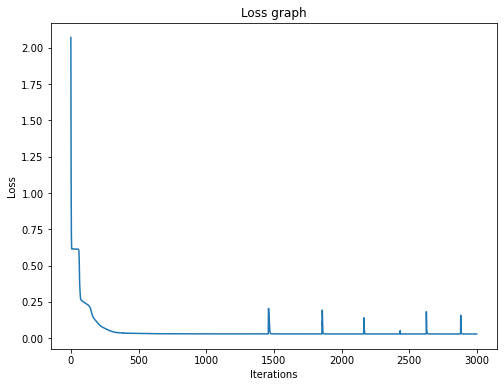

In [47]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model5.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

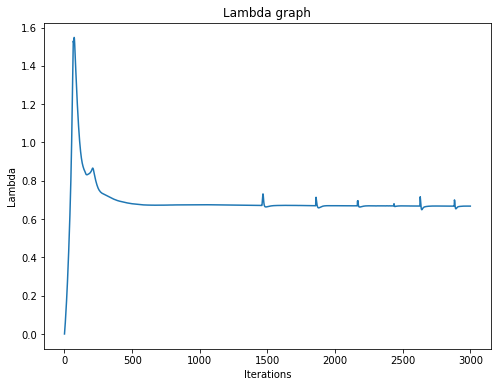

In [48]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model5.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()